# Grover's Algorithm and Matched Filtering

Here we will consider trying to find the frequency of a sine wave signal from amongst a number of known frequencies when the signal start time and amplitudes are known. Time domain data $\mathcal{D}$ of length $N$ is taken from the signal and compared to $M$ templates $\mathcal{T}$ of sine waves of known frequencies equally spaced out in the frequency space of interest.

## Matched Filtering (just inner product)

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# N is the number of data points
N = 1024
# M is the number of templates
M = int(2**(5))

In [3]:
# The signal is a sinosoid with a random frequency:
f_data = np.random.uniform(0.5,1.)
# The templates have frequencies spread uniformly over the desired range:
f_template = np.linspace(0.5,1.,M)

In [4]:
x=np.linspace(0.,1.,N)

# Noisless data samples and templates are produced
Data = np.sin(f_data*x*(2*np.pi))
Templates = np.sin(f_template*np.vstack(x)*(2*np.pi))

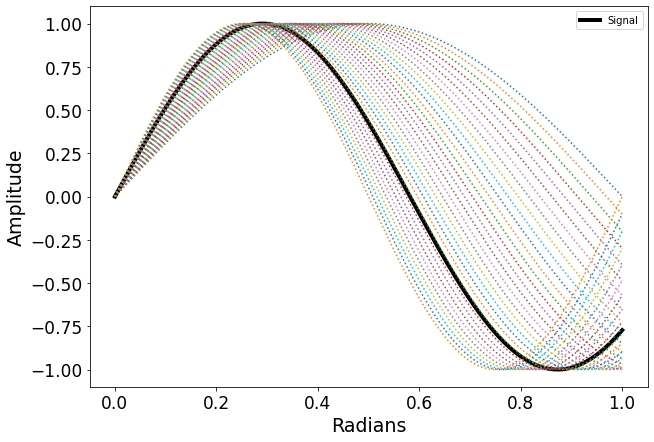

In [5]:
if M<1025:
    plt.figure(figsize=(10,7))
    plt.plot(x,Data,label='Signal',lw=4, color='black')
    plt.plot(x,Templates,ls=':')
    plt.xlabel('Radians')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

**Figure:** The signal (black) is plotted against the templates (colored dotted).

I do not calculate SNR between the signal and templates (there is no noise yet) but instead just calculate the inner product and set a threshold value of $\overrightarrow{\mathcal{D}}\ \cdot\ \overrightarrow{\mathcal{T}}>0.999$ (maybe change this to selecting the location of maximum $\overrightarrow{\mathcal{D}}\ \cdot\ \overrightarrow{\mathcal{T}}$ to ensure there is only 1 matching template until *quantum counting* is implemented). The result from the inner product for each template is printed below:

In [6]:
# Calculating the norm of each vector
norm_T = np.linalg.norm(Templates,axis=0)
norm_D = np.linalg.norm(Data)

# Calculating the normalised inner product between data and templates
dot = np.dot(Data,Templates)/(norm_T*norm_D)
print(dot)

[0.24080914 0.29620267 0.3536767  0.41250345 0.47180893 0.53062041
 0.58793422 0.64279434 0.69436823 0.74200591 0.78527257 0.82395179
 0.85802328 0.88762346 0.91299871 0.93445921 0.95233891 0.96696416
 0.97863104 0.98759053 0.99403983 0.99811814 0.99990557 0.9994242
 0.99664072 0.99147043 0.98378266 0.97340805 0.96014812 0.94378755
 0.92410965 0.90091499]


# Grover's Algorithm

We assume there is only 1 matching template $\mathcal{T}_{0}$. Grover's algorithm is then applied as follows:

1. Create operator $\hat{U}_{w}=\mathcal{I}-2|w⟩⟨w|$ where $w$ is the matrix position corresponding to the template $\mathcal{T}_{0}$. This operator has the property:

$$ \hat{U}_{w} |x⟩ = -|x⟩ \text{ if } x=w, $$
$$ \hat{U}_{w} |x⟩ = |x⟩ \text{ if } x\ne w.\ \ \$$

2. Initiate superposition:

$$ |s⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{x=0}|x⟩, $$

assuming that every template is equally likely to have the correct template without any more prior knowledge.

3. Create the Grover diffusion operator $\hat{U}_{s}=2|s⟩⟨s|-\mathcal{I}$.

4. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to $|s⟩$.

5. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to the result $\sqrt{M}$ times.

$\hat{U}_{w}$ can be created from the inner product threshold previously set:

In [7]:
diag = np.where(1-dot<1e-3,-1,1)
U_w = np.eye(M)*diag

In [8]:
k_T=(M-np.sum(diag))/2
print(str(k_T)+' match(es) to find!')

2.0 match(es) to find!


$\hat{U}_{w}$ =

In [9]:
print(U_w)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


This produces a diagonal matrix with 1s on the diagonal where the condition is not met and -1s where the condition is met (idealy there should only be one -1).

$|s⟩$ can be defined as so:

In [10]:
s_i = np.array([np.ones(M)/np.sqrt(M)]).T

$|s⟩=$

In [11]:
print(s_i.shape)

(32, 1)


and $\hat{U}_{s}$ can be made from this:

In [12]:
U_s = 2*np.outer(s_i,s_i)-np.eye(M)

$\hat{U}_{s}$ = 

In [13]:
print(U_s)

[[-0.9375  0.0625  0.0625 ...  0.0625  0.0625  0.0625]
 [ 0.0625 -0.9375  0.0625 ...  0.0625  0.0625  0.0625]
 [ 0.0625  0.0625 -0.9375 ...  0.0625  0.0625  0.0625]
 ...
 [ 0.0625  0.0625  0.0625 ... -0.9375  0.0625  0.0625]
 [ 0.0625  0.0625  0.0625 ...  0.0625 -0.9375  0.0625]
 [ 0.0625  0.0625  0.0625 ...  0.0625  0.0625 -0.9375]]


# One Qubit Quantum Counting

Rather than choosing $P$ states to evaluate the period with, we decide how many decimal places we wish to know the period to. This is chosen by some precision parameter $m$:

In [14]:
m=5

## Controlled Grovers Gate

A matrix that forms of an arbitrary operator is created by $\sum|\text{output}⟩⟨\text{input}|$. The gate we wish to construct here is a controlled Grovers Gate:

$$c-U^x: |x⟩|\phi⟩ \longmapsto |x⟩U^x|\phi⟩. $$

In this way our gate matrix should be:

$$c-U^x= |x⟩|\phi⟩⟨x|U^x⟨\phi|. $$

In [15]:
#for the first qubit (how to represent all the possibility, all the different x states |0> means no operation but |1> means 1...)
#maybe write this as a function so can be called multiple times
#for other qubits, which naively I think should just be the above function but repeated 2^n times,n being the nth qubit
#this should give me a possibility of favouring 0 or 1 state 
def ControlGate (n,inputM):
    #n denotes which qubit we are discussing 
    #initialise the output matrix
    outerinput=inputM
    output=[]
    for p in np.arange(2):
        output.append(np.dot(np.linalg.matrix_power(np.matmul(U_s,U_w),p+2**n),outerinput[p]))
    return np.array(output)

Let us define our input state which is the tensor product of our 1 qubit ancillary state and our template states:

In [16]:
#doing the tensor produxt of (|0>+|1>) and |s> to create the input state 
outerinput = (1./np.sqrt(2*M))*np.ones((2,M))
print(outerinput)

[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
  0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
  0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
  0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
  0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]


We apply the constrol gate mentioned above iterably $m$ times:

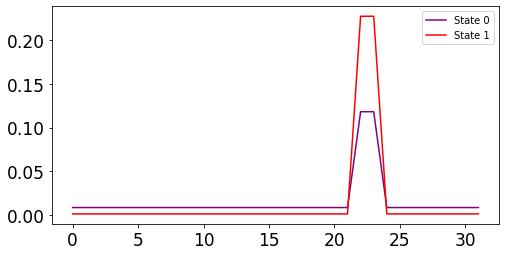

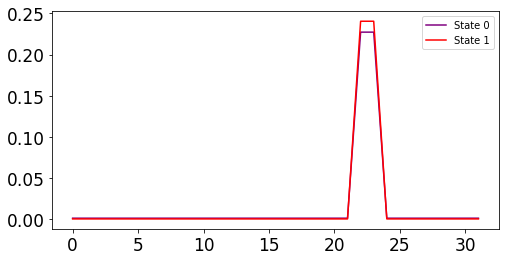

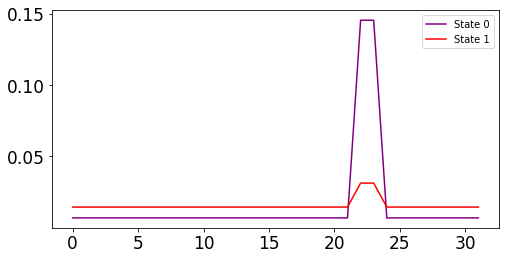

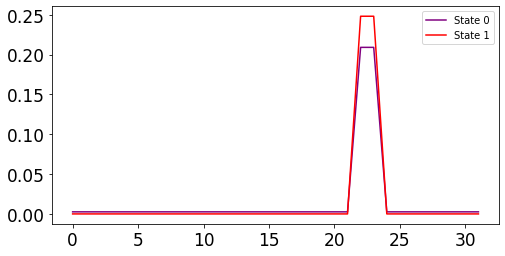

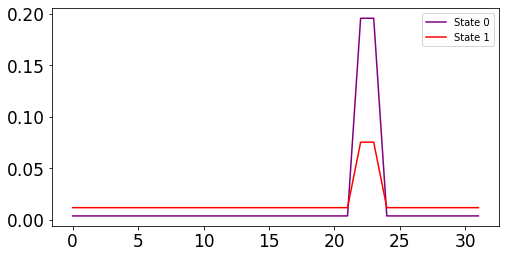

Ancilla register result for each iteration: [1.6875, 1.6875, 0.6875, 1.6875, 0.6875]
Value for theta: 1.009765625


In [17]:
#MEASUREMENT
digits=[]
theta=0
for p in np.arange(m):
    output= ControlGate(p,outerinput)
    pos_p=np.argmax(np.absolute(output)**2)/M
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(0,M),np.absolute(output[0])**2,color='purple', label='State 0')
    plt.plot(np.arange(0,M),np.absolute(output[1])**2,color='red', label='State 1')
    theta+=np.power(2,float(p-m))*pos_p
    digits.append(pos_p)
    plt.legend()
    plt.show()
print('Ancilla register result for each iteration:',digits)
print(r'Value for theta:',theta)

The result seems unpredictable. I assume the reason is because every time we took a measurement it could either gives us $\theta$ or $2\pi-2\theta$. So for every qubit measurement it is random which one the outcome corresponds to.

In [18]:
k=M*np.sin(theta)**2
print('Predicted number of matching templates is '+str(int(np.round(k))))
print('True number of matching templates is '+str(int(np.round(k_T))))

Predicted number of matching templates is 23
True number of matching templates is 2
